In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *


%matplotlib inline

In [21]:
cup_df = pd.read_csv(
    '../data/ML-CUP23-TR.csv',
    index_col=0,
    comment='#',
    header=None,
    names=['feature_' + str(i+1) for i in range(10)] + ['target_' + str(i+1) for i in range(3)]
)

data_set = cup_df.values
len_data = len(data_set)
np.random.shuffle(data_set)

training_len = int(0.8*len_data)

training_set = data_set[:int(training_len)] # Training Set for KFold Cross Validation
test_set = data_set[int(training_len):] # Hold Out Test Set

TR_OUTPUT = 3
TR_INPUT = data_set.shape[1] - TR_OUTPUT

scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(training_set[:,:TR_INPUT])
scaler_out.fit(training_set[:,TR_INPUT:])

tr_normalized = np.empty((training_len, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(training_set[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(training_set[:,TR_INPUT:])

test_normalized = np.empty((len_data - training_len, TR_OUTPUT + TR_INPUT))
test_normalized[:,:TR_INPUT] = scaler_in.transform(test_set[:,:TR_INPUT])
test_normalized[:,TR_INPUT:] = scaler_out.transform(test_set[:,TR_INPUT:])

In [22]:
tr_normalized[-200:].shape

(200, 13)

In [23]:
cup_df.head(1)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_1,target_2,target_3
1,-0.877168,-0.927493,-0.448759,0.844105,0.959141,0.99909,0.892554,-0.849822,-0.159111,0.338186,4.743561,-53.45127,8.895408


In [24]:
gs_results = pd.read_csv('../data/gs_data/test.csv')

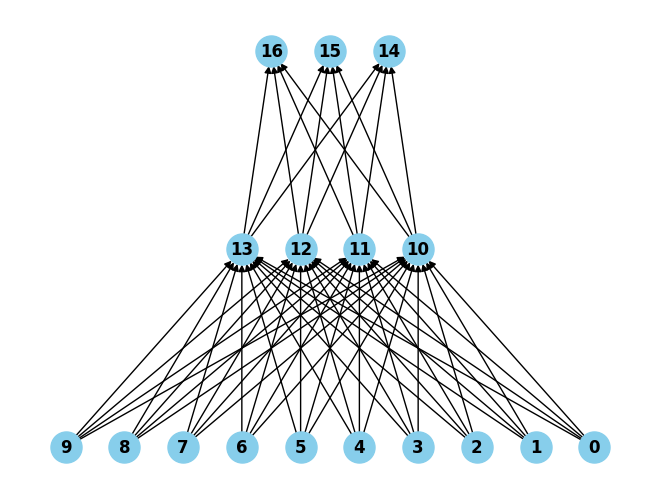

In [25]:
top_used = ast.literal_eval(gs_results['topology'][0])
gs_results_stats = gs_results.drop(['stats', 'topology'], axis=1)
NeuralNetwork.display_topology(top_used)

In [26]:
gs_results_stats.head(1)

,adamax,adamax_learning_rate,batch_size,error_increase_tolerance,exp_decay_rate_1,exp_decay_rate_2,lambda_tikhonov,max_epochs,min_epochs,patience,mean_mean_euclidean_error,mean_mean_squared_error,val_mean_euclidean_error,val_mean_squared_error,mean_best_validation_training_error
0,True,0.02,40,0.00001,0.9,0.999,0.001,100,20,5,1.671141,3.067125,0.000521,0.00323,3.055129


In [27]:
order_by = 'mean_mean_euclidean_error'
gs_results_stats.sort_values(by=[order_by], inplace=True)
for i in gs_results_stats.columns:
    gs_results_stats[i] = gs_results_stats[i].astype(float)
gs_results_stats.reset_index(drop=True, inplace=True)
gs_results_stats.style.background_gradient(cmap='Blues')

,adamax,adamax_learning_rate,batch_size,error_increase_tolerance,exp_decay_rate_1,exp_decay_rate_2,lambda_tikhonov,max_epochs,min_epochs,patience,mean_mean_euclidean_error,mean_mean_squared_error,val_mean_euclidean_error,val_mean_squared_error,mean_best_validation_training_error
0,1.000000,0.020000,16.000000,0.000010,0.900000,0.999000,0.000100,100.000000,10.000000,5.000000,1.552753,2.652190,0.003383,0.042647,2.617754
1,1.000000,0.020000,16.000000,0.000010,0.900000,0.999000,0.000100,100.000000,20.000000,5.000000,1.607062,2.812346,0.003957,0.040412,2.797638
2,1.000000,0.010000,16.000000,0.000010,0.900000,0.999000,0.001000,100.000000,10.000000,5.000000,1.666030,2.994215,0.000303,0.003689,3.000282
3,1.000000,0.010000,16.000000,0.000010,0.900000,0.999000,0.000100,100.000000,10.000000,5.000000,1.667655,3.035827,0.000225,0.000054,3.032866
4,1.000000,0.020000,40.000000,0.000010,0.900000,0.999000,0.001000,100.000000,10.000000,5.000000,1.668206,3.022950,0.000297,0.005600,3.022314
5,1.000000,0.020000,16.000000,0.000010,0.900000,0.999000,0.001000,100.000000,20.000000,5.000000,1.668299,2.995010,0.000229,0.003662,2.994169
6,1.000000,0.020000,16.000000,0.000010,0.900000,0.999000,0.001000,100.000000,10.000000,5.000000,1.670608,2.989421,0.000051,0.000130,2.986862
7,1.000000,0.010000,16.000000,0.000010,0.900000,0.999000,0.001000,100.000000,20.000000,5.000000,1.671089,3.003242,0.000264,0.002858,2.998663
8,1.000000,0.020000,40.000000,0.000010,0.900000,0.999000,0.001000,100.000000,20.000000,5.000000,1.671141,3.067125,0.000521,0.003230,3.055129
9,1.000000,0.010000,40.000000,0.000010,0.900000,0.999000,0.001000,100.000000,20.000000,5.000000,1.677349,3.066903,0.000696,0.006766,3.038556


In [28]:
first_nan = gs_results_stats.loc[gs_results_stats[gs_results_stats.columns[-1]].isna()].index
last_index = gs_results_stats.index[-1]

In [29]:
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results_stats.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results_stats.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
maps = {'adamax optimizer': adamax_opt_col,
        'standard optimizer': st_opt_col,
        'general': general_col,
        'metrics': metrics_col,
}
# groups and trace visibilities
group = []
vis = []
visList = []
for m in maps.keys():
    for col in gs_results_stats.columns:
        if col in maps[m]:
            vis.append(True)
        else:
            vis.append(False)
    group.append(m)
    visList.append(vis)
    vis = []


In [30]:
minmaxsc = MinMaxScaler()
orig_col = list(gs_results_stats)
norm_gs_results_stats = pd.DataFrame(data=minmaxsc.fit_transform(gs_results_stats), columns=gs_results_stats.columns)
norm_gs_results_stats = norm_gs_results_stats.join(gs_results_stats, rsuffix='_r')

In [ ]:
def plot_gs(df, title):
    fig = px.line(norm_gs_results_stats, y=orig_col, title='GridSearch values compared')
    if len(first_nan) > 0:
        fig.add_vrect(x0=first_nan, x1=last_index, line_width=0, fillcolor="red", opacity=0.2)
    fig.update_layout(xaxis_range=[0, last_index])
    fig.update_yaxes(showticklabels=False)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")

    # buttons for each group
    buttons = []
    for i, g in enumerate(group):
        button =  dict(label=g,
                    method = 'restyle',
                        args = ['visible',visList[i]])
        buttons.append(button)

    buttons = [{'label': 'all',
                    'method': 'restyle',
                    'args': ['visible', [True, True, True, True, True, True]]}] + buttons
    fig.update_layout(
        updatemenus=[
            dict(
            type="dropdown",
            direction="down",
            buttons = buttons)
        ],
    )

    return fig

In [36]:
plot_gs(norm_gs_results_stats, 'GridSearch normalized values')

In [37]:
plot_gs(gs_results_stats, 'GridSearch values')

In [35]:
np.seterr(all='raise')
training_set = cup_df.iloc[:-266]
validation_set = cup_df.iloc[-266:]
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error] 

batch_size = 5
error_increase_tolerance = 0.0001
lambda_tikhonov = 0.0001
max_epochs = 800
min_epochs = 100
patience = 10

adamax = True
adamax_learning_rate = 0.02/batch_size
exp_decay_rate_1 = 0.9
exp_decay_rate_2 = 0.999

learning_rate = 0.005/batch_size
alpha_momentum = 0
lr_decay_tau = 250
eta_tau = learning_rate/100

NN = NeuralNetwork(relu_l2, -0.75, 0.75, True, RANDOM_STATE + 1)
stats = NN.train(tr_normalized[:-266], tr_normalized[-266:], 
                 batch_size = batch_size, 
                 max_epochs = max_epochs, 
                 error_increase_tolerance = error_increase_tolerance, 
                 patience = patience, 
                 min_epochs = min_epochs, 
                 lambda_tikhonov = lambda_tikhonov, 
                 metrics = metrics, 
                 
                 learning_rate=learning_rate,
                 alpha_momentum=alpha_momentum,
                 lr_decay_tau=lr_decay_tau,
                 eta_tau=eta_tau,
                 
                 adamax=adamax,
                 adamax_learning_rate = adamax_learning_rate,
                 exp_decay_rates_1 = exp_decay_rate_1,
                 exp_decay_rates_2 = exp_decay_rate_2,
                 
                 collect_data=True,
                 collect_data_batch=True,
                 verbose=True)

NameError: name 'relu_l2' is not defined

In [ ]:
tr_predictions_normalized = NN.predict_array(tr_normalized[:-100,:TR_INPUT])
tr_predictions = scaler_out.inverse_transform(tr_predictions_normalized)

In [ ]:
pd.options.mode.chained_assignment = None
pred_cols = ['prediction_' + str(i + 1) for i in range(TR_OUTPUT)]
cup_df[pred_cols].iloc[:-100] = tr_predictions
for col in pred_cols:
    cup_df[col + '_err'] = (cup_df[col] - cup_df['output_' + col[-1]])**2

'''
tr_df_normalized[pred_cols] = tr_predictions_normalized
for col in pred_cols:
    tr_df_normalized[col + '_err'] = (tr_df_normalized[col] - tr_df_normalized['output_' + col[-1]])**2'''

In [ ]:
tr_df.sample(5, random_state=RANDOM_STATE)

In [ ]:
val_predictions_normalized = NN.predict_array(val_normalized[:,:TR_INPUT])
val_predictions = scaler_out.inverse_transform(val_predictions_normalized)

In [ ]:
val_df[pred_cols] = val_predictions
for col in pred_cols:
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2


val_df_normalized[pred_cols] = val_predictions_normalized
for col in pred_cols:
    val_df_normalized[col + '_err'] = (val_df_normalized[col] - val_df_normalized['output_' + col[-1]])**2

In [ ]:
val_df.sample(5, random_state=RANDOM_STATE)

In [ ]:
for key in list(stats.keys())[:12]:
    print(key, ':', stats[key])

In [ ]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

In [ ]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

In [ ]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

In [ ]:
tr_df.sample(5, random_state=RANDOM_STATE)

In [ ]:
val_df.sample(5, random_state=RANDOM_STATE)

In [ ]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_predictions[sorted_order][:,i] , training_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

In [ ]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_predictions[sorted_order][:,i] , validation_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

In [ ]:
for i in range(1, TR_OUTPUT + 1):
    multy_plot_3d([tr_df['input_1'].values, tr_df['input_1'].values], 
              [tr_df['input_2'].values, tr_df['input_2'].values],
              [tr_df['output_' + str(i)].values, tr_df['prediction_' + str(i)].values],
              [['input_1', 'input_2', 'target_val'], ['input_1', 'input_2', 'output_val']],
              'Output_' + str(i));


In [ ]:
for i in range(1, TR_OUTPUT + 1):
    interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'prediction_' + str(i), 'prediction_' +str(i) + '_err').show()
    interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'output_' + str(i), 'prediction_' +str(i) + '_err').show()

In [ ]:
for i, neuron in enumerate(reversed(NN.neurons[-NN.output_size:])):
    print('index unit:',neuron.index, '| act fun:' ,neuron.f.__name__, '| corresp output:', tr_df.columns[-(i+1) - 1])

In [ ]:
for neuron in NN.neurons[NN.input_size:]:
    print('index unit:', neuron.index, '| act fun:' ,neuron.f.__name__)